In [1]:
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math
import h5py
import os.path
from catheter import preprocess_period, preprocess_length


# Period based data

/home/tingtaoz/storage/traindatalevy/allparams/0823/sample169_U020uf15.0606alpha1.5tauR2_5.4794_18.9053_27.6349.h5


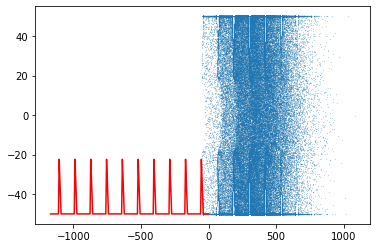

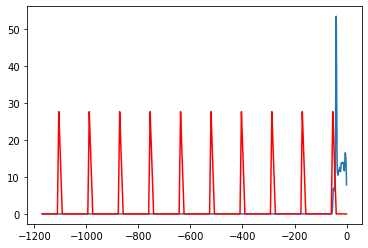

In [2]:
pref_folder = "/groups/esm/dzhuang/Catheter/allparam"
train_data_folder = "/home/tingtaoz/storage/traindatalevy/allparams/0823"
info_file = "/home/tingtaoz/storage/traindatalevy/allparams/0823/params.txt"

# Study the effect of bw_method
t = 9
ind = 5

data_info = np.genfromtxt(info_file, delimiter=',', skip_header=1)
file_names = glob.glob(train_data_folder+"/sample*")
file_name = file_names[ind]
print(file_name)
ncx1, ncx2, ncx3, ncx4 = 50, 50, 50, 50 
n_periods = 10
x_mesh, y_mesh, x_b, y_b, xx, density_1d_data,  my_data = preprocess_period(ind, t,  data_info, file_name, 
                                                                     ncx1=ncx1, ncx2=ncx2, ncx3=ncx3, ncx4=ncx4, n_periods=n_periods)

sample, uf, L_p, x1, x2, x3, h = my_data

plt.figure()
plt.scatter(x_b, y_b, s=0.01)
plt.plot(x_mesh, y_mesh - 50, color="red")

# density 
plt.figure()
plt.plot(xx,  density_1d_data)
plt.plot(x_mesh, y_mesh, color="red")

In [3]:
pref_folder = "/groups/esm/dzhuang/Catheter/allparam/period"
train_data_folder = "/home/tingtaoz/storage/traindatalevy/allparams/0823"
info_file = "/home/tingtaoz/storage/traindatalevy/allparams/0823/params.txt"
data_info = np.genfromtxt(info_file, delimiter=',', skip_header=1)
file_names = glob.glob(train_data_folder+"/sample*")

ncx1, ncx2, ncx3, ncx4 = 50, 50, 50, 50 
ncx = ncx1 + ncx2 + ncx3 + ncx4
n_periods = 10

n_data = len(file_names)
density_1d_data = np.zeros((n_periods*ncx+1, n_data))
x_mesh, y_mesh = np.zeros((n_periods*ncx+1, n_data)), np.zeros((n_periods*ncx+1, n_data))
data_info_all = np.zeros((7, n_data))
# change t
t = 9
file_names = glob.glob(train_data_folder+"/sample*")
for ind in range(n_data):
    file_name = file_names[ind]
    sample  = np.int64(  file_name[file_name.find("sample") + len("sample"):  file_name.find("_U")]  )
    uf  = np.float64(  file_name[file_name.find("uf") + len("uf"):  file_name.find("alpha")]  )
    # sample is from 1 - 1000
    n_ind = 3*(sample - 1) 
    if uf < (5.0 + 10.0)/2:
        n_ind += 0
    elif uf < (10. + 15.0)/2:
        n_ind += 1
    elif uf < (15. + 20.0)/2:
        n_ind += 2
    else:
        print("error! uf = ", uf)
        
    x_mesh[:,  n_ind], y_mesh[:,  n_ind], x_b, y_b, xx, density_1d_data[:,  n_ind],  data_info_all[:,  n_ind] = preprocess_period(ind, t,  data_info, file_name, 
                                                                     ncx1=ncx1, ncx2=ncx2, ncx3=ncx3, ncx4=ncx4, n_periods=n_periods)

np.save(pref_folder+"/density_1d_data.npy", density_1d_data)
np.save(pref_folder+"/x_1d_structured_mesh.npy",   x_mesh)
np.save(pref_folder+"/y_1d_structured_mesh.npy",   y_mesh)
np.save(pref_folder+"/data_info.npy",   data_info_all)

# Length based data

/home/tingtaoz/storage/traindatalevy/allparams/0823/sample965_U020uf5.02273alpha1.5tauR2_2.91931_27.3843_25.5099.h5


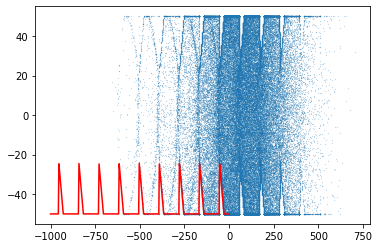

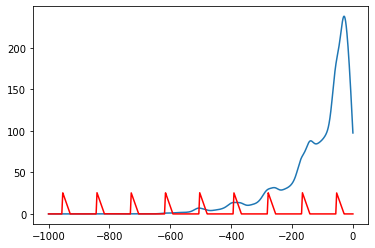

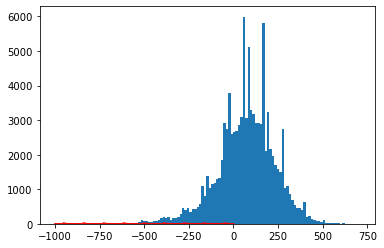

In [20]:
pref_folder = "/groups/esm/dzhuang/Catheter/allparam"
train_data_folder = "/home/tingtaoz/storage/traindatalevy/allparams/0823"
info_file = "/home/tingtaoz/storage/traindatalevy/allparams/0823/params.txt"
# Study the effect of bw_method
t = 9
ind = 10

data_info = np.genfromtxt(info_file, delimiter=',', skip_header=1)
file_names = glob.glob(train_data_folder+"/sample*")
file_name = file_names[ind]
print(file_name)
N_s, L_x = 2001, 1000
x_mesh, y_mesh, x_b, y_b, xx, density_1d_data,  my_data = preprocess_length(ind, t,  data_info, file_name, 
                                                                     N_s = N_s, L_x = L_x)

sample, uf, L_p, x1, x2, x3, h = my_data

plt.figure()
plt.scatter(x_b, y_b, s=0.01)
plt.plot(x_mesh, y_mesh - 50, color="red")

# density 
plt.figure()
plt.plot(xx,  density_1d_data)
plt.plot(x_mesh, y_mesh, color="red")

# density 
plt.figure()
plt.hist(x_b,  bins = 100)
plt.plot(x_mesh, y_mesh, color="red")

In [5]:
pref_folder = "/groups/esm/dzhuang/Catheter/allparam/length"
train_data_folder = "/home/tingtaoz/storage/traindatalevy/allparams/0823"
info_file = "/home/tingtaoz/storage/traindatalevy/allparams/0823/params.txt"
data_info = np.genfromtxt(info_file, delimiter=',', skip_header=1)
file_names = glob.glob(train_data_folder+"/sample*")

N_s, L_x = 2001, 1000

n_data = len(file_names)
density_1d_data = np.zeros((N_s, n_data))
x_mesh, y_mesh = np.zeros((N_s, n_data)), np.zeros((N_s, n_data))
data_info_all = np.zeros((7, n_data))
# change t
t = 9
file_names = glob.glob(train_data_folder+"/sample*")

for ind in range(n_data):
    file_name = file_names[ind]
    sample  = np.int64(  file_name[file_name.find("sample") + len("sample"):  file_name.find("_U")]  )
    uf  = np.float64(  file_name[file_name.find("uf") + len("uf"):  file_name.find("alpha")]  )
    # sample is from 1 - 1000
    n_ind = 3*(sample - 1) 
    if uf < (5.0 + 10.0)/2:
        n_ind += 0
    elif uf < (10. + 15.0)/2:
        n_ind += 1
    elif uf < (15. + 20.0)/2:
        n_ind += 2
    else:
        print("error! uf = ", uf)
        
    x_mesh[:,  n_ind], y_mesh[:,  n_ind], x_b, y_b, xx, density_1d_data[:,  n_ind],  data_info_all[:,  n_ind] = preprocess_length(ind, t,  data_info, file_name, 
                                                                     N_s = N_s, L_x = L_x)

np.save(pref_folder+"/density_1d_data.npy", density_1d_data)
np.save(pref_folder+"/x_1d_structured_mesh.npy",   x_mesh)
np.save(pref_folder+"/y_1d_structured_mesh.npy",   y_mesh)
np.save(pref_folder+"/data_info.npy",   data_info_all)